In [3]:
from __future__ import division
from bunch import Bunch
from collections import defaultdict
from functools import partial
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import palettable
from pneumodel.plotting import save_figure, remove_spines
import scipy.stats
import sys

In [4]:
%matplotlib inline
COLORS = ['.3'] + palettable.colorbrewer.qualitative.Dark2_8.mpl_colors

## Useful data functions

In [5]:
def read_trial_logs(output_folder, trial_folder):
  # store configuration details for each trial arm in dictionary
  config_path = os.path.join(output_folder, 'configuration', 'configuration.json')
  with open(config_path) as f:
    config = json.load(f, object_hook=lambda d: Bunch(d))
  trial_config = Bunch()
  for a in config.simulation.trial_arms: 
    trial_config[a.name] = a
  
  # get the event logs
  logs_path = os.path.join(output_folder, trial_folder, 'trial_logs')
  col_names = ['id', 'day', 'event', 'serotype', 'day_of_colonization', 'vaccine_name']
  arms = Bunch()
  for f in os.listdir(logs_path):
    if f.endswith('.csv'):
      name = f[:-4]
      arms[name] = Bunch(
        log=pd.read_csv(os.path.join(logs_path, f), header=None, names=col_names),
        config=trial_config[name]
      )
  return arms

### Sample size calculation

Test for equality, two sample proportions http://hansheng.gsm.pku.edu.cn/pdf/2007/prop.pdf

In [6]:
def sample_size(p1, p2, a=0.05, b=0.8):
  p1 = np.array(p1)
  p2 = np.array(p2)
  z_half_a = scipy.stats.norm.ppf(1 - a / 2.)
  z_b      = scipy.stats.norm.ppf(b)
  e        = p1 - p2
  return 2 * (((z_half_a + z_b)**2) / (e**2)) * (p1 * (1 - p1) + p2 * (1 - p2))

### Incidence

In [7]:
def get_incidence(arm, fup_days, serotype=None):
  # follow-up begins day after last dose
  first_day = arm.config.start_year * 365 + max(arm.config.schedule) + 1
  
  # an incident is a colonization event within the followup period
  is_incident = (arm.log.event == 'Colonization') & (arm.log.day >= first_day) & (arm.log.day <= first_day + fup_days)
  if serotype:
    is_incident = is_incident & (arm.log.serotype == serotype)
  
  # incidence rate is number of incidents / person-days
  num_incidents = np.sum(is_incident)
  person_days = arm.config.num_subjects * fup_days # assumes no one dies
  return num_incidents / person_days

### Duration

In [8]:
def get_mean_duration(arm, fup_days, serotype=None, first_day=None):
  # follow-up begins day after last dose
  if first_day is None:
    first_day = arm.config.start_year * 365 + max(arm.config.schedule) + 1
  else:
    first_day = arm.config.start_year * 365 + first_day
  
  # get all the recovery events within our followup period, whose day of colonization occurred after vaccination
  is_recovery = (arm.log.event == 'Recovery') & (arm.log.day_of_colonization >= first_day) & (arm.log.day < first_day + fup_days)
  if serotype:
    is_recovery = is_recovery & (arm.log.serotype == serotype)
  
  # calculate durations from information logged in the recovery events
  recoveries = arm.log[is_recovery]
  durations = recoveries.day - recoveries.day_of_colonization
  return durations.mean()

### Prevalence 

In [9]:
def get_num_colonized(hosts, serotypes=None):
  count = 0
  for host_id, carriage in hosts.iteritems():
    if serotypes:
      is_colonized = any(s in carriage for s in serotypes)
    else:
      is_colonized = len(carriage) > 0
    
    if is_colonized:
      count += 1
  return count

In [10]:
def get_prevalence(arm, fup_days, serotypes=None):
  hosts = defaultdict(list)
  previous_day = 0
  sample_days = (arm.config.start_year * 365 + max(arm.config.schedule) + d for d in fup_days)
  next_sample_day = next(sample_days)
  for index, row in arm.log.iterrows():
    if row.day >= next_sample_day and previous_day < next_sample_day:
      yield float(get_num_colonized(hosts, serotypes)) / arm.config.num_subjects # assumes no ones dies during trial
      try:
        next_sample_day = next(sample_days)
      except StopIteration:
        return
    
    if row.event == 'Colonization':
      hosts[row.id].append(row.serotype)
    elif row.event == 'Recovery':
      hosts[row.id].remove(row.serotype)
    elif row.event == 'Death':
      if hosts.has_key(row.id):
        del hosts[row.id]
    
    previous_day = row.day

## Analysis  

### Basic stats: prevalence, incidence rate, mean duration

In [16]:
OUTPUT_FOLDER = "/Users/ocsicnarf/Github/Pneumo-Model/outputs/WCV-PAPER/wcv-trial-kenya-e-0.1"
TRIAL_FOLDER = "trial-0"
FIGURES_FOLDER = os.path.join(OUTPUT_FOLDER, 'figures', TRIAL_FOLDER)
save_fig = partial(save_figure, folder=FIGURES_FOLDER, exts=['pdf', 'png'], dpi=300)

In [17]:
ARMS = read_trial_logs(OUTPUT_FOLDER, TRIAL_FOLDER)

## Age-specific mean duration

For fitting purposes, look at control arms. Pick up age ranges corresponding to http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3433858/figure/JIS447F2/

In [18]:
start_days = np.array([k * (6 * 30) for k in range(1, 10)])

In [20]:
ys

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/WCV-PAPER/wcv-trial-kenya-e-0.1/figures/trial-0/age-specific-mean-duration-control-infant-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/WCV-PAPER/wcv-trial-kenya-e-0.1/figures/trial-0/age-specific-mean-duration-control-infant-0.png']

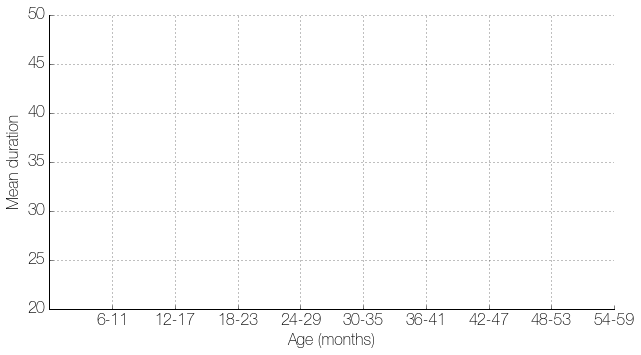

In [19]:
arm_name = 'control-infant'
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
xs = start_days / 30
ys = np.array([get_mean_duration(ARMS[arm_name], 6 * 30, first_day=d) for d in start_days])
ax.plot(xs, ys, marker='o')
ax.set_ylim(20, 50)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.grid()
ax.set_xlabel('Age (months)')
ax.set_xticks(xs)
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(x, x + 5) for x in xs])
ax.set_ylabel('Mean duration')
remove_spines(ax)
fig.tight_layout()
save_fig(fig, 'age-specific-mean-duration-{}'.format(arm_name))

## Age-specific Prevalence

In [388]:
%%time
fup_days = [k * 30 for k in range(25)]
ctrl_arm = ARMS['control-infant']
ctrl_traj = list(get_prevalence(ctrl_arm, fup_days))

CPU times: user 24.9 s, sys: 261 ms, total: 25.1 s
Wall time: 25.7 s


[(0, 0.7278), (1, 0.8152), (2, 0.8546), (3, 0.881), (4, 0.8842), (5, 0.886), (6, 0.8916), (7, 0.8928), (8, 0.8858), (9, 0.8748), (10, 0.8676), (11, 0.8702), (12, 0.8736), (13, 0.873), (14, 0.8626), (15, 0.8498), (16, 0.8394), (17, 0.8276), (18, 0.8068), (19, 0.789), (20, 0.772), (21, 0.758), (22, 0.7386), (23, 0.7078), (24, 0.6904)]


['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1/figures/trial-0/age-specific-prevalence-2.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1/figures/trial-0/age-specific-prevalence-2.png']

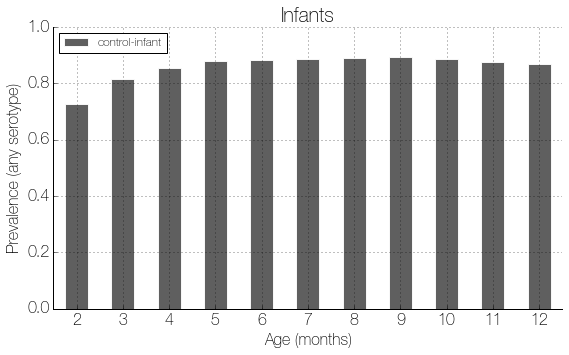

In [389]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# prevalence in control infants
#xs = np.array(fup_days)

days_old = np.array(fup_days) + max(ctrl_arm.config.schedule)
ys = ctrl_traj
xs = np.arange(len(ys))
ax.bar(xs, ys, color=COLORS[0], label='control-infant', alpha=0.9, align='center', width=0.5)
ax.set_title('Infants')
ax.set_ylim(0., 1.0)
ax.set_ylabel('Prevalence (any serotype)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
ax.set_xticks(xs)
ax.set_xticklabels(['{:.0f}'.format(d / 30) for d in days_old])
ax.set_xlim(-0.5, 10.5)
ax.set_xlabel('Age (months)')

remove_spines(ax) 
ax.grid(True)
ax.legend(frameon=True, loc='upper left', fontsize=12)

print zip(xs, ys)
fig.tight_layout()
save_fig(fig, 'age-specific-prevalence')

##  Look at vaccine arms

In [270]:
%%time
f = open(os.path.join(FIGURES_FOLDER, 'statistics.txt'), 'w')
f.write('--Prevalence at baseline, and 30-day intervals--\n')
for name in sorted(ARMS.keys()):
  f.write("{}: {}\n".format(name, list(get_prevalence(ARMS[name], [30 * i for i in range(7)]))))

f.write('--Incidence--\n')
for name in sorted(ARMS.keys()):
  f.write("{}: {} episodes/yr\n".format(name, 365 * get_incidence(ARMS[name], 2 * 365)))
  
serotype = '6A'
f.write('--Incidence ({}) --\n'.format(serotype))
for name in sorted(ARMS.keys()):
  f.write("{}: {} episodes/yr\n".format(name, 365 * get_incidence(ARMS[name], 2 * 365, serotype)))
  
f.write('--Mean Duration--\n')
for name in sorted(ARMS.keys()):
  f.write("{}: {} days\n".format(name, get_mean_duration(ARMS[name], 2 * 365)))
f.close()

CPU times: user 1min 10s, sys: 978 ms, total: 1min 11s
Wall time: 1min 24s


### Susceptibility Reduction control 

#### Expectation: A SR vaccine should reduce incidence.

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/SR-vs-incidence-1.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/SR-vs-incidence-1.png']

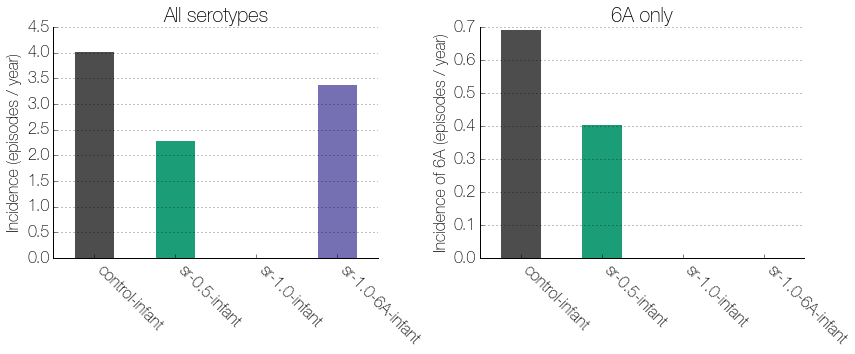

In [285]:
arm_names = ('control-infant', 'sr-0.5-infant', 'sr-1.0-infant', 'sr-1.0-6A-infant')
fup_days = 2 * 365
serotype = '6A'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# incidence of any serotype
ax = axes[0]
ys = np.array([365 * get_incidence(ARMS[name], fup_days) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('All serotypes')
ax.set_ylim(0)
ax.set_ylabel('Incidence (episodes / year)')
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')

# incidence of specified serotype
ax = axes[1]
ys = np.array([365 * get_incidence(ARMS[name], fup_days, serotype) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('6A only')
ax.set_ylim(0)
ax.set_ylabel('Incidence of {} (episodes / year)'.format(serotype))
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')

fig.tight_layout()

save_fig(fig, 'SR-vs-incidence')

#### How does SR vaccine affect duration?

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/SR-vs-duration-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/SR-vs-duration-0.png']

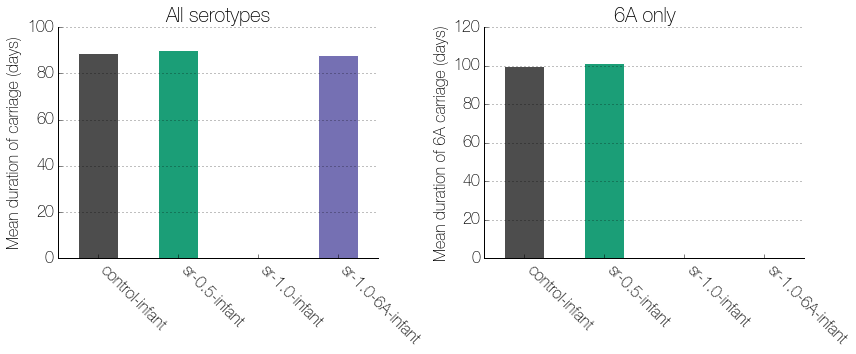

In [286]:
arm_names = ('control-infant', 'sr-0.5-infant', 'sr-1.0-infant', 'sr-1.0-6A-infant')
fup_days = 2 * 365
serotype = '6A'
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# duration of any serotype
ax = axes[0]
ys = np.array([get_mean_duration(ARMS[name], fup_days) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('All serotypes')
ax.set_ylim(0)
ax.set_ylabel('Mean duration of carriage (days)')
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')

# duration of specified serotype
ax = axes[1]
ys = np.array([get_mean_duration(ARMS[name], fup_days, serotype) for name in arm_names])
ys = np.nan_to_num(ys)
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('6A only')
ax.set_ylim(0)
ax.set_ylabel('Mean duration of 6A carriage (days)'.format(serotype))
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')

fig.tight_layout()

save_fig(fig, 'SR-vs-duration')

### Duration-reduction vaccines 

#### Sanity check: look at mean duration of colonization. 

It should go down with increasing vaccine strength (as measured in colonization equivalents)

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-duration-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-duration-0.png']

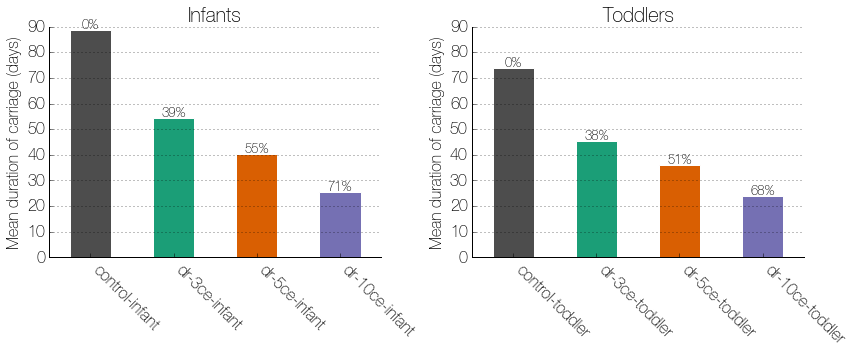

In [287]:
fup_days = 2 * 365
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# duration in infants
arm_names = ('control-infant', 'dr-3ce-infant', 'dr-5ce-infant', 'dr-10ce-infant')
ax = axes[0]
ys = np.array([get_mean_duration(ARMS[name], fup_days) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('Infants')
#ax.set_ylim(0, 35)
ax.set_ylabel('Mean duration of carriage (days)')
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')
for x, y in zip(xs, ys):
  r = 1.0 - y / ys[0]
  ax.text(x, y, '{:.0f}%'.format(r * 100), va='bottom', ha='center', color='k', fontsize=13)
  
# duration in toddlers
arm_names = ('control-toddler', 'dr-3ce-toddler', 'dr-5ce-toddler', 'dr-10ce-toddler')
ax = axes[1]
ys = np.array([get_mean_duration(ARMS[name], fup_days) for name in arm_names])
ys = np.nan_to_num(ys)
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('Toddlers')
ax.set_ylim(0, axes[0].get_ylim()[1])
ax.set_ylabel('Mean duration of carriage (days)'.format(serotype))
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')
for x, y in zip(xs, ys):
  r = 1.0 - y / ys[0]
  ax.text(x, y, '{:.0f}%'.format(r * 100), va='bottom', ha='center', color='k', fontsize=13)

fig.tight_layout()

save_fig(fig, 'DR-vs-duration')

#### Mean duration of one serotype (19F) over time

Controls for different intrinsic mean durations

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-duration-of-19F-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-duration-of-19F-0.png']

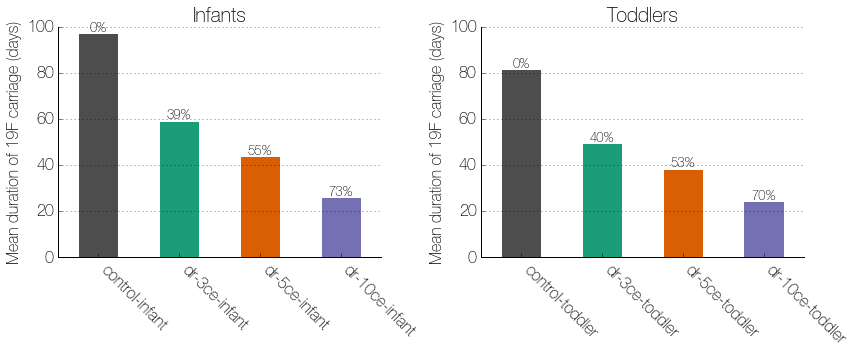

In [288]:
fup_days = 2 * 365
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
serotype = '19F'

# duration in infants
arm_names = ('control-infant', 'dr-3ce-infant', 'dr-5ce-infant', 'dr-10ce-infant')
ax = axes[0]
ys = np.array([get_mean_duration(ARMS[name], fup_days, serotype) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('Infants')
#ax.set_ylim(0, 35)
ax.set_ylabel('Mean duration of {} carriage (days)'.format(serotype))
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')
for x, y in zip(xs, ys):
  r = 1.0 - y / ys[0]
  ax.text(x, y, '{:.0f}%'.format(r * 100), va='bottom', ha='center', color='k', fontsize=13)
  
# duration in toddlers
arm_names = ('control-toddler', 'dr-3ce-toddler', 'dr-5ce-toddler', 'dr-10ce-toddler')
ax = axes[1]
ys = np.array([get_mean_duration(ARMS[name], fup_days, serotype) for name in arm_names])
ys = np.nan_to_num(ys)
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('Toddlers')
ax.set_ylim(0, axes[0].get_ylim()[1])
ax.set_ylabel('Mean duration of {} carriage (days)'.format(serotype))
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')
for x, y in zip(xs, ys):
  r = 1.0 - y / ys[0]
  ax.text(x, y, '{:.0f}%'.format(r * 100), va='bottom', ha='center', color='k', fontsize=13)

fig.tight_layout()

save_fig(fig, 'DR-vs-duration-of-{}'.format(serotype))

### Effect of DR vaccines on incidence

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-incidence-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-incidence-0.png']

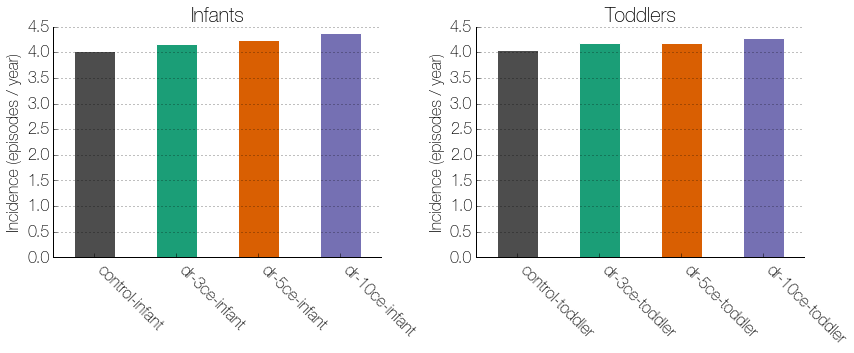

In [289]:
fup_days = 2 * 365

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# incidence in infants
arm_names = ('control-infant', 'dr-3ce-infant', 'dr-5ce-infant', 'dr-10ce-infant')
ax = axes[0]
ys = np.array([365 * get_incidence(ARMS[name], fup_days) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('Infants')
ax.set_ylim(0)
ax.set_ylabel('Incidence (episodes / year)')
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')


# incidence in toddlers
arm_names = ('control-toddler', 'dr-3ce-toddler', 'dr-5ce-toddler', 'dr-10ce-toddler')
ax = axes[1]
ys = np.array([365 * get_incidence(ARMS[name], fup_days) for name in arm_names])
xs = np.arange(len(ys))

ax.bar(xs, ys, color=COLORS[:4], align='center', width=0.5)
ax.set_title('Toddlers')
ax.set_ylim(0)
ax.set_ylabel('Incidence (episodes / year)')
ax.set_xticks(xs)
ax.set_xticklabels(arm_names, rotation=-45, ha='left')
remove_spines(ax) 
ax.yaxis.grid(True, which='major')



fig.tight_layout()

save_fig(fig, 'DR-vs-incidence')

####  Look at prevalence, measured at different times (days from date of last vaccine dose)

Generate the data first, takes a bit of time (~2-3 minutes)

In [290]:
%%time
trajectories = {}
fup_days = [k * 30 for k in range(25)]
for name in ARMS.keys():
  trajectories[name] = list(get_prevalence(ARMS[name], fup_days))
  sys.stdout.write('.')
  sys.stdout.flush()

...........CPU times: user 2min 15s, sys: 1.84 s, total: 2min 17s
Wall time: 2min 22s


['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-prevalence-over-time-1.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-prevalence-over-time-1.png']

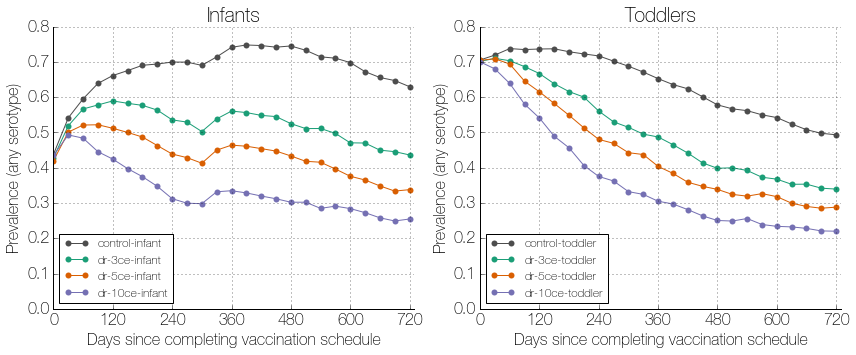

In [292]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# prevalence in infants
arm_names = ('control-infant', 'dr-3ce-infant', 'dr-5ce-infant', 'dr-10ce-infant')
ax = axes[0]
for i, name in enumerate(arm_names):
  xs = fup_days
  ys = trajectories[name]
  
  ax.plot(xs, ys, color=COLORS[i], marker='o', label=name)
  ax.set_title('Infants')
  ax.set_ylim(0, 0.8)
  ax.set_ylabel('Prevalence (any serotype)')
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
  ax.set_xlim(0, max(xs) + 10)
  ax.set_xlabel('Days since completing vaccination schedule')

  remove_spines(ax) 
  ax.grid(True)
  ax.legend(frameon=True, loc='best', fontsize=12)
  
# prevalence in toddlers
arm_names = ('control-toddler', 'dr-3ce-toddler', 'dr-5ce-toddler', 'dr-10ce-toddler')
ax = axes[1]

for i, name in enumerate(arm_names):
  xs = fup_days
  ys = trajectories[name]
  
  ax.plot(xs, ys, color=COLORS[i], marker='o', label=name)
  ax.set_title('Toddlers')
  ax.set_ylim(0, axes[0].get_ylim()[1])
  ax.set_ylabel('Prevalence (any serotype)')
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
  ax.set_xlim(0, max(xs) + 10)
  ax.set_xlabel('Days since completing vaccination schedule')

  remove_spines(ax) 
  ax.grid(True)
  ax.legend(frameon=True, loc='lower left', fontsize=12)

fig.tight_layout()
save_fig(fig, 'DR-vs-prevalence-over-time')

#### Sample size

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-sample-size-over-time-0.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR-vs-sample-size-over-time-0.png']

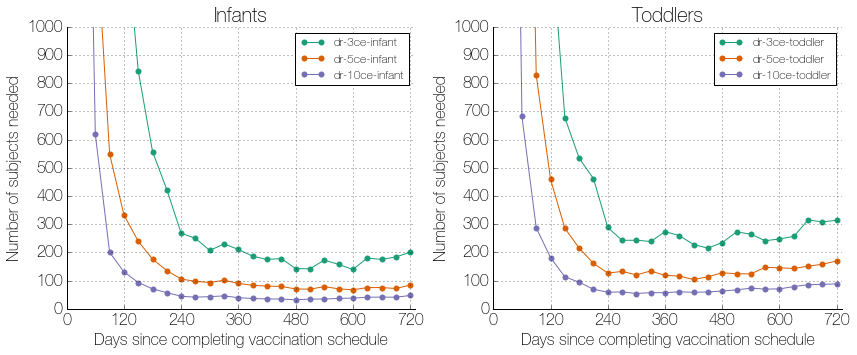

In [293]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# sample size in infants
control_traj = trajectories['control-infant']
arm_names = ('dr-3ce-infant', 'dr-5ce-infant', 'dr-10ce-infant')
ax = axes[0]
for i, name in enumerate(arm_names):
  xs = fup_days
  ys = sample_size(control_traj, trajectories[name])
  
  ax.plot(xs, ys, color=COLORS[i + 1], marker='o', label=name)
  ax.set_title('Infants')
  ax.set_ylim(0, 1000)
  ax.set_ylabel('Number of subjects needed')
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
  ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
  ax.set_xlim(0, max(xs) + 10)
  ax.set_xlabel('Days since completing vaccination schedule')

  remove_spines(ax) 
  ax.grid(True)
  ax.legend(frameon=True, loc='best', fontsize=12)
  
# sample size in toddlers
control_traj = trajectories['control-toddler']
arm_names = ('dr-3ce-toddler', 'dr-5ce-toddler', 'dr-10ce-toddler')
ax = axes[1]
for i, name in enumerate(arm_names):
  xs = fup_days
  ys = sample_size(control_traj, trajectories[name])
  
  ax.plot(xs, ys, color=COLORS[i + 1], marker='o', label=name)
  ax.set_title('Toddlers')
  ax.set_ylim(0, axes[0].get_ylim()[1])
  #ax.set_ylim(1e1, 1e5)
  ax.set_ylabel('Number of subjects needed')
  #ax.set_yscale('log')
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
  ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
  ax.set_xlim(0, max(xs) + 10)
  ax.set_xlabel('Days since completing vaccination schedule')

  remove_spines(ax) 
  ax.grid(True)
  ax.legend(frameon=True, loc='best', fontsize=12)

fig.tight_layout()
save_fig(fig, 'DR-vs-sample-size-over-time')

### Look again at SR vaccines, in terms of prevalence

['/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR+SR-vs-prevalence-over-time-1.pdf',
 '/Users/ocsicnarf/Github/Pneumo-Model/outputs/wcv-trial-kenya-e-0.1-beta-0.1/figures/trial-0/DR+SR-vs-prevalence-over-time-1.png']

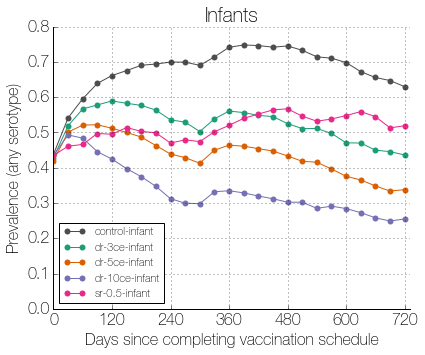

In [295]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))

# prevalence in infants
arm_names = ('control-infant', 'dr-3ce-infant', 'dr-5ce-infant', 'dr-10ce-infant', 'sr-0.5-infant')
ax = axes
for i, name in enumerate(arm_names):
  xs = fup_days
  ys = trajectories[name]
  
  ax.plot(xs, ys, color=COLORS[i], marker='o', label=name)
  ax.set_title('Infants')
  ax.set_ylim(0, 0.8)
  ax.set_ylabel('Prevalence (any serotype)')
  ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(120))
  ax.set_xlim(0, max(xs) + 10)
  ax.set_xlabel('Days since completing vaccination schedule')

  remove_spines(ax) 
  ax.grid(True)
  ax.legend(frameon=True, loc='best', fontsize=11)
  
fig.tight_layout()
save_fig(fig, 'DR+SR-vs-prevalence-over-time')